In [17]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

In [10]:
#Colour palettes = for plotting later
all_amps = ['PD7153_TET2a',
            'PD7151_TET2a',
            'JP001_TET2a',
            'PD7153_TET2b',
            'PD7151_TET2b',
            'JP001_TET2b_g',
            'PD7153_SRSF2',
            'JP001_SRSF2',
            'PD7153_CUX1',
            'JP001_RUNX1_g'
           ]
short_label = ['TET2[a]',
               'TET2[a]',
               'TET2[a]',
               'TET2[b]',
               'TET2[b]',
               'TET2[b]',
               'SRSF2',
               'SRSF2',
               'CUX1',
               'RUNX1'
              ]
relabel = dict(zip(all_amps, short_label))
colors = sns.color_palette('husl', n_colors = len(all_amps))
allVAFcols = dict(zip(all_amps, colors))

In [11]:
filename = '../Data/Amp_data/clean_anon_allele_counts_resc_2.tsv'

In [12]:
#Import the clean data
df = pd.read_csv(filename, index_col = [0, 1, 2, 3], sep = '\t')
df = df.unstack(level = 3)
df.columns = ['MT', 'WT']
df['tot_reads'] = df['MT'] + df ['WT']
df['Plate'] = df.index.get_level_values(0)
df['Well'] = df.index.get_level_values(1)
df['Amplicon'] = df.index.get_level_values(2)
df[['Patient', 'one', 'two']] = df['Amplicon'].str.split('_', expand = True)
df = df.drop(columns = ['one', 'two', 'MT', 'WT'])

#Import information about plate cell type and patient
key = pd.read_excel('../Data/Amp_data/Amplicon_metadata_fixed_anon.xlsx', sheet_name = 'PlateID')
key = key.drop(['Cell Origin', 'Plate Nr', 'Plate Name','Nr of cells'], axis=1)
key.rename(columns = {'Comments2':'Plate'}, inplace = True)
key.rename(columns = {'Cell-group':'Celltype'}, inplace = True)
plate_cell_dict = dict(zip(key.Plate, key.Celltype))

#Add in and standardise cell types
df['celltype'] = df['Plate'].replace(plate_cell_dict)
rename = {'CD34+halfCD38-': 'CD34', 'CD34+/38-':'CD34', 'CD34+':'CD34', 'NEs':'Neut', 'Monocytes': 'Mono', 'nBCs': 'nBC'}
df['celltype'].replace(rename, inplace = True) #df now contains cell type as well, standardised for all plates
amplicons = df['Amplicon'].drop_duplicates().to_list()
ctypes = ['CD34', 'Mono', 'Neut', 'nBC']
df.set_index(['Plate', 'Well','celltype', 'Amplicon'], inplace = True)
patients = df['Patient'].drop_duplicates().to_list()


#Split into single plottable df for each patient
all_df = {}
for pt in patients:
    df2 = df.copy()
    df2 = df2.loc[df['Patient'].isin([pt])]
    df2 = df2.drop(columns = 'Patient')
    df2 = df2.unstack(3)
    cols = list(df2.columns.get_level_values(level=1))
    df2.columns = cols
    all_df[pt] = df2
    
#all_df['JP001']    

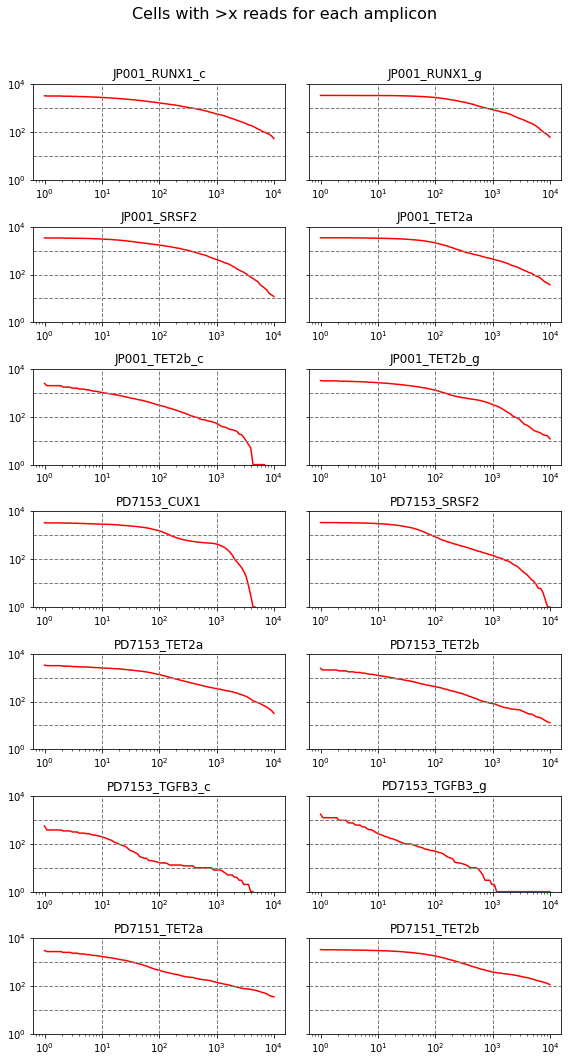

In [14]:
#Plot all amplicons separately

fig, ax = plt.subplots(7, 2, figsize = (8, 14), gridspec_kw = dict(height_ratios = [1, 1, 1, 1, 1, 1, 1]),  sharey = True) 

ax = ax.ravel()

for i, a in enumerate(amplicons): #enumerate amps instead to skip amplicons that look awful
    p = a.split('_')[0]
    plot_df = all_df[p].copy() 
    x = np.logspace(0, 4, 100) 
    y = [plot_df.loc[(plot_df[a] >= xi)].shape[0] for xi in x]
    ax[i].plot(x, y, color = 'red')
    
    if i != [8, 9]:
        ax[i].set_xticklabels([])
    else:
        ax[i].set_xlabel('reads')
        
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1, 10000)
    #ax[i].set_xlim(1, 10000)
    ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].set_title(f'{a}')  

fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1.05)     
fig.tight_layout(h_pad = 1, w_pad = 2)    

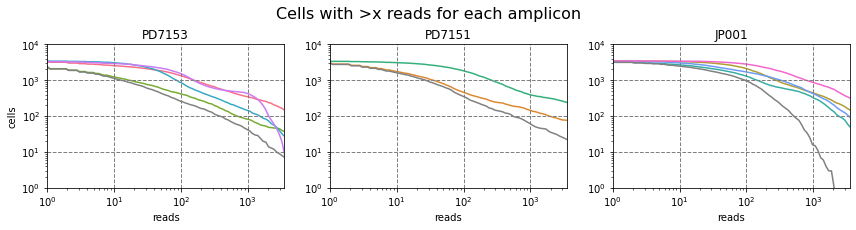

In [15]:
#Plot amplicons for each patient on single plot - match colors to VAF plots
patients = ['PD7153', 'PD7151', 'JP001'] #reorder

fig, ax = plt.subplots(1, 3, figsize = (12, 3)) 

ax = ax.ravel()

for i, p in enumerate(patients):
    plot_df = all_df[p].copy()
    c = plot_df.columns
    d = []
    for a in all_amps:
        if a not in c:
            continue
        else:
            x = np.logspace(0, 4, 100) 
            y = [plot_df.loc[(plot_df[a] >= xi)].shape[0] for xi in x]
            ax[i].plot(x, y, color = allVAFcols[a])
            if a != 'PD7153_CUX1':
                d.append(a)
    
    allplot = plot_df[d] #excludes CUX1 for plotting all reads
    
    x = np.logspace(0, 4, 100)     
    y = [allplot.loc[(allplot >= xi).all(axis=1)].shape[0] for xi in x]
    ax[i].plot(x, y, color = 'gray')
    
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1, 10000)
    ax[i].set_xlim(1, 3500)
    ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].set_xlabel('reads') 
    ax[0].set_ylabel('cells') 
    
    ax[i].set_title(f'{p}')  

fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1.05)     
fig.tight_layout(h_pad = 1, w_pad = 2)    

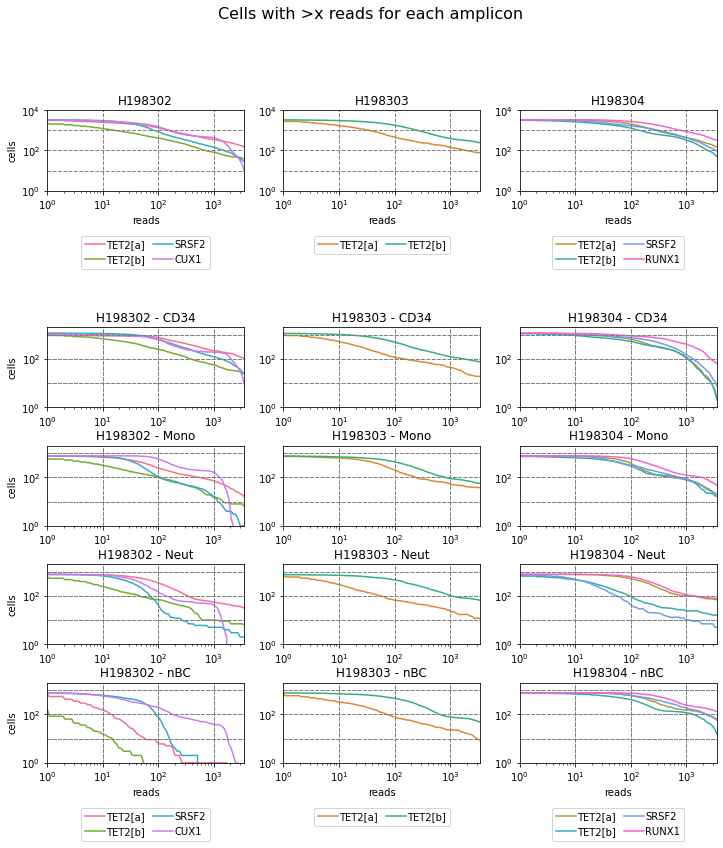

In [19]:
#Plot for paper figure

#Create proxy artists for legend
JP001_labels = [ 'JP001_TET2a',  'JP001_TET2b_g', 'JP001_SRSF2', 'JP001_RUNX1_g']
JP001_handles = []
for lab in JP001_labels:
    line = Line2D([0], [0], label=lab, color=allVAFcols[lab])
    JP001_handles.append(line)
JP001_labels_r = [relabel.get(x) for x in JP001_labels]    

PD7153_labels = [ 'PD7153_TET2a', 'PD7153_TET2b','PD7153_SRSF2', 'PD7153_CUX1']
PD7153_handles = []
for lab in PD7153_labels:
    line = Line2D([0], [0], label=lab, color=allVAFcols[lab])
    PD7153_handles.append(line)
PD7153_labels_r = [relabel.get(x) for x in PD7153_labels]  

PD7151_labels = ['PD7151_TET2a', 'PD7151_TET2b']
PD7151_handles = []
for lab in PD7151_labels:
    line = Line2D([0], [0], label=lab, color=allVAFcols[lab])
    PD7151_handles.append(line)
PD7151_labels_r = [relabel.get(x) for x in PD7151_labels]  

#Plot amplicons for each patient on single plot by cell type - match colors to VAF plots

alt_id = ['H198302', 'H198303', 'H198304']
pt_label = dict(zip(patients, alt_id))

fig, ax = plt.subplots(6, 3, figsize = (12, 12), gridspec_kw = dict(height_ratios = [2,1.5, 2,2,2,2], hspace = 0.5)) 

ax = ax.ravel()


for i, p in enumerate(patients):
    plot_df = all_df[p].copy()
    c = plot_df.columns
    d = []
    for a in all_amps:
        if a not in c:
            continue
        else:
            x = np.logspace(0, 4, 100) 
            y = [plot_df.loc[(plot_df[a] >= xi)].shape[0] for xi in x]
            ax[i].plot(x, y, color = allVAFcols[a])
            if a != 'PD7153_CUX1':
                d.append(a)
    
    #Extra code plots cells with >x reads for all amplicons except CUX1
    #allplot = plot_df[d]
    
    #x = np.logspace(0, 4, 100)     
    #y = [allplot.loc[(allplot >= xi).all(axis=1)].shape[0] for xi in x]
    #ax[i].plot(x, y, color = 'gray')
    
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_ylim(1, 10000)
    ax[i].set_xlim(1, 3500)
    ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
    ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray') 
    label = pt_label[p]
    ax[i].set_title(f'{label}')  


for l, p in enumerate(patients):
    plot_df2 = all_df[p].copy()
    c = plot_df2.columns
    plot_df2['celltype'] = plot_df2.index.get_level_values(2)
    
    for k, ct in enumerate(ctypes):
        i = (k*3) + l + 6
        plot_df3 = plot_df2.loc[plot_df2['celltype'].isin([ct])]
        
        for a in all_amps:
            if a not in c:
                continue
            else:
                x = np.logspace(0, 4, 100) 
                y = [plot_df3.loc[(plot_df3[a] >= xi)].shape[0] for xi in x]
                ax[i].plot(x, y, color = allVAFcols[a])
        
                ax[i].set_yscale('log')
                ax[i].set_xscale('log')
                ax[i].set_ylim(1, 2000)
                ax[i].set_xlim(1, 3500)
                ax[i].axvline(10, ls = '--', lw = 1, color = 'gray')
                ax[i].axvline(100, ls = '--', lw = 1, color = 'gray')
                ax[i].axvline(1000, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(10, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(100, ls = '--', lw = 1, color = 'gray')
                ax[i].axhline(1000, ls = '--', lw = 1, color = 'gray')
                label = pt_label[p]
                ax[i].set_title(f'{label} - {ct}')  
                
ax[0].set_xlabel('reads') 
ax[1].set_xlabel('reads') 
ax[2].set_xlabel('reads') 
ax[15].set_xlabel('reads') 
ax[16].set_xlabel('reads') 
ax[17].set_xlabel('reads') 

ax[0].set_ylabel('cells') 
ax[6].set_ylabel('cells')
ax[9].set_ylabel('cells')
ax[12].set_ylabel('cells')
ax[15].set_ylabel('cells')

ax[3].remove()
ax[4].remove()
ax[5].remove()

ax[2].legend(handles = JP001_handles, labels = JP001_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[0].legend(handles = PD7153_handles, labels = PD7153_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[1].legend(handles = PD7151_handles, labels = PD7151_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)

ax[17].legend(handles = JP001_handles, labels = JP001_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[15].legend(handles = PD7153_handles, labels = PD7153_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)
ax[16].legend(handles = PD7151_handles, labels = PD7151_labels_r, loc = 'upper center',bbox_to_anchor = [0.5,-0.5], ncol = 2, columnspacing = 0.8, handletextpad=0.1, markerscale = 1)


fig.suptitle('Cells with >x reads for each amplicon', fontsize=16, y = 1)     
fig.savefig(f'../Results/All_reads_per_amplicon_Sfig.png',bbox_inches='tight', dpi = 600)
fig.savefig(f'../Results/All_reads_per_amplicon_Sfig.svg',bbox_inches='tight', dpi = 600)